In this notebook, we built several models with 'train_merge.csv'.

The classification algorithms used are Logistic Regression, Random Forest Classifier, LGBM Classifier and XGB Classifier.

To solve the problem of imbalanced data, we tested 3 methods:
- RandomUnderSampling
- RandomOverSampling
- SMOTE

In this notebook, we have not applied cross validation to speed up the process.

For each model, AUC was calculated for test and training sets, precision and recall for test set. The confusion matrix and graphs showing the most important variables were also displayed.

Remark: 
- RandomForestClassifier overfit (AUC for training set equal to 1 and AUC for test set is not as great).
- We got the best score with LGBM Classifier et RandomOverSampling.

We will therefore use LGBM Classifier and RandomOverSampling when we apply cross-validations and optimize hyperparameters. We will not test the other methods given the time that it will take.

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
import re
import gc
import sys

# 2. Load Data

In [2]:
train_merge = pd.read_csv('train_merge.csv')

In [3]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [4]:
sns.set_theme(style='darkgrid')

# 3. Model

In [5]:
train = train_merge.copy()

In [6]:
gc.enable()
del train_merge
gc.collect()

80

In [7]:
# Extract the ids
train_ids = train['SK_ID_CURR']
    
# Extract the labels for training
labels = train['TARGET']
    
# Remove the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [8]:
categorical_features_1 = []
categorical_features_2 = []

for col in train.select_dtypes(['object', 'bool']):
    if len(list(train[col].unique())) <= 2:
        categorical_features_1.append(col)
    else:
        categorical_features_2.append(col)

In [9]:
numerical_features = train.select_dtypes(['float64', 'int64']).columns.tolist()

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [11]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 3113.01 MB
Memory usage after optimization is: 992.12 MB
Decreased by 68.1%


In [12]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler(feature_range=(0, 1)))
categorical_pipeline_1 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OrdinalEncoder())
categorical_pipeline_2 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown = 'ignore'))

In [13]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline_1, categorical_features_1), (categorical_pipeline_2, categorical_features_2))

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(train, labels, test_size=0.20, random_state=42)

In [15]:
def conf_matrix(y_test, pred):
    con_mat = confusion_matrix(y_test, pred)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(4, 4))
    plt.title('Confusion Matrix', size=15)
    sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [16]:
def get_column_names_from_ColumnTransformer(column_transformer):
    """
    Helper function which explores a Column Transformer to get feature names
    Parameters
    ----------
    column_transformer: a sklearn column_transformer
    Returns
    ----------
    a list of strings of the column names of the outputs of the colun_transformer
    """
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        if isinstance(transformer, OneHotEncoder):
            if isinstance(raw_col_name, str):
                names = transformer.get_feature_names(input_features=[raw_col_name])
            else:
                names = transformer.get_feature_names(input_features=raw_col_name)
        elif isinstance(transformer, PolynomialFeatures):
            names = transformer.get_feature_names(input_features=raw_col_name)
        else:
            try:
                names = transformer.get_feature_names()
            except AttributeError:
                # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)
    return col_name

### 3.1. Logistic Regression

#### With Under Sampling

In [17]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)

In [18]:
model_lr = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [19]:
model_lr.fit(X_train_rus, Y_train_rus)
pred_1 = model_lr.predict_proba(X_test)
pred_1 = pred_1[:, 1]

[13:12:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
auc_1 = roc_auc_score(Y_test, pred_1)
print('AUC: ', auc_1)

AUC:  0.7733940370082296


In [21]:
pred_1_t = model_lr.predict_proba(X_train_rus)
pred_1_t = pred_1_t[:, 1]
auc_1_t = roc_auc_score(Y_train_rus, pred_1_t)
print('AUC: ', auc_1_t)

AUC:  0.7783537667893932


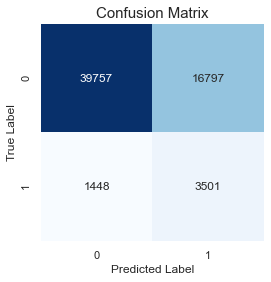

In [22]:
pred_test = model_lr.predict(X_test)
conf_matrix(Y_test, pred_test)

In [23]:
precision_1 = precision_score(Y_test, pred_test)
recall_1 = recall_score(Y_test, pred_test)

print('precision: ', precision_1)
print('recall: ', recall_1)

precision:  0.17248004729530003
recall:  0.707415639523136


In [24]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lr['columntransformer'])):
    if bool:
        new_features.append(feature)

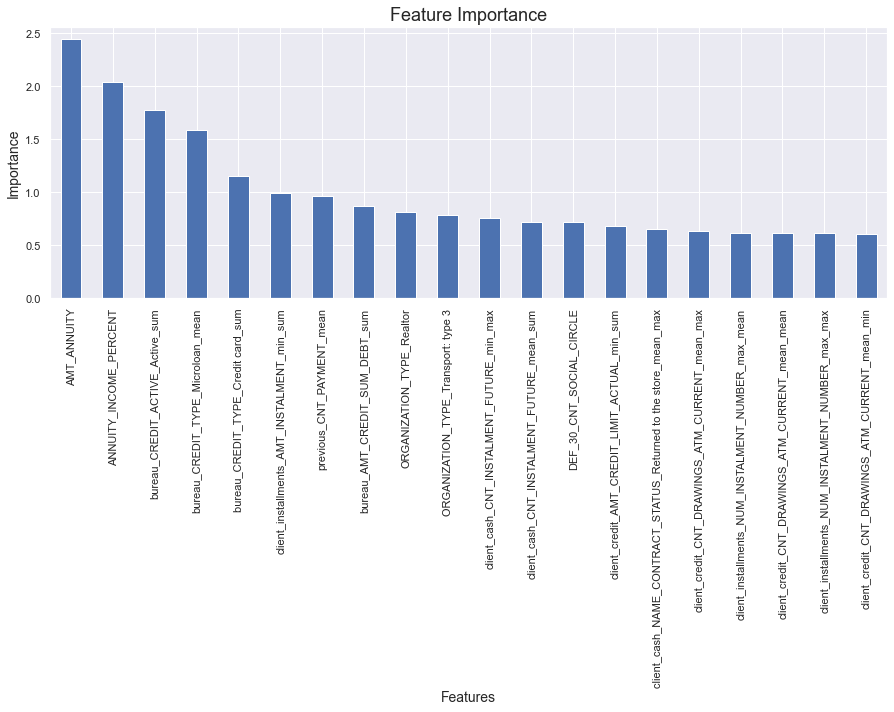

In [25]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [26]:
ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros = ros.fit_resample(X_train, Y_train)

In [27]:
model_lr = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [28]:
model_lr.fit(X_train_ros, Y_train_ros)
pred_2 = model_lr.predict_proba(X_test)
pred_2 = pred_2[:, 1]

[13:31:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
auc_2 = roc_auc_score(Y_test, pred_2)
print('AUC: ', auc_2)

AUC:  0.772485280475841


In [30]:
pred_2_t = model_lr.predict_proba(X_train_ros)
pred_2_t = pred_2_t[:, 1]
auc_2_t = roc_auc_score(Y_train_ros, pred_2_t)
print('AUC: ', auc_2_t)

AUC:  0.7768722319666804


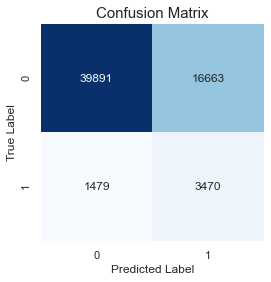

In [31]:
pred_test = model_lr.predict(X_test)
conf_matrix(Y_test, pred_test)

In [32]:
precision_2 = precision_score(Y_test, pred_test)
recall_2 = recall_score(Y_test, pred_test)

print('precision: ', precision_2)
print('recall: ', recall_2)

precision:  0.17235384691799532
recall:  0.7011517478278441


In [33]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lr['columntransformer'])):
    if bool:
        new_features.append(feature)

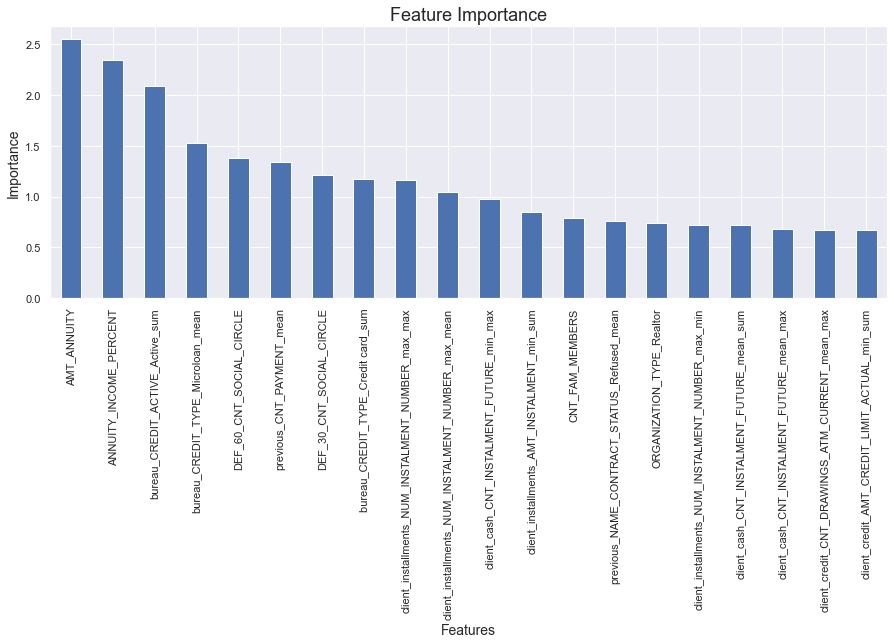

In [34]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [35]:
X_train_smo = preprocessor.fit_transform(X_train)
X_test_smo = preprocessor.fit_transform(X_test)

In [36]:
X_train_smo = pd.DataFrame(X_train_smo, columns=get_column_names_from_ColumnTransformer(preprocessor))
X_test_smo = pd.DataFrame(X_test_smo, columns=get_column_names_from_ColumnTransformer(preprocessor))

In [37]:
smo = SMOTE(random_state=42)
X_train_smo, Y_train_smo = smo.fit_resample(X_train_smo, Y_train)

In [38]:
model_lr = make_pipeline(SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [39]:
model_lr.fit(X_train_smo, Y_train_smo)
pred_3 = model_lr.predict_proba(X_test_smo)
pred_3 = pred_3[:, 1]

[13:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
auc_3 = roc_auc_score(Y_test, pred_3)
print('AUC: ', auc_3)

AUC:  0.7393078317035839


In [41]:
pred_3_t = model_lr.predict_proba(X_train_smo)
pred_3_t = pred_3_t[:, 1]
auc_3_t = roc_auc_score(Y_train_smo, pred_3_t)
print('AUC: ', auc_3_t)

AUC:  0.7825755663288801


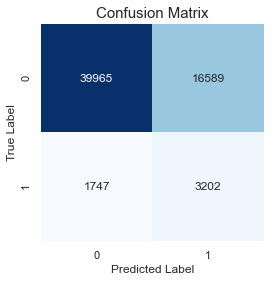

In [42]:
pred_test = model_lr.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [43]:
precision_3 = precision_score(Y_test, pred_test)
recall_3 = recall_score(Y_test, pred_test)

print('precision: ', precision_3)
print('recall: ', recall_3)

precision:  0.16179071295033096
recall:  0.6469993938169327


In [44]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

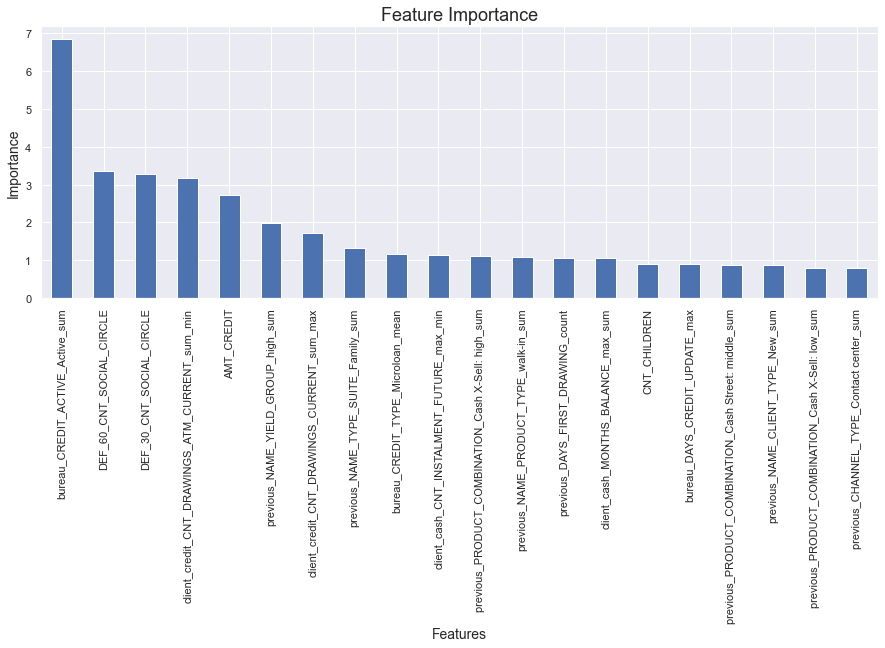

In [45]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index=new_features, columns=['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending=False)[:20].plot.bar(y='Importance')
plt.title('Feature Importance', fontsize=18)
plt.xlabel('Features', size=14)
plt.ylabel('Importance', size=14)
plt.show()

### 3.2. Random Forest Classifier

#### With Under Sampling

In [46]:
model_rfc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [47]:
model_rfc.fit(X_train_rus, Y_train_rus)
pred_4 = model_rfc.predict_proba(X_test)
pred_4 = pred_4[:, 1]

[14:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
auc_4 = roc_auc_score(Y_test, pred_4)
print('AUC: ', auc_4)

AUC:  0.7468179908668876


In [49]:
pred_4_t = model_rfc.predict_proba(X_train_rus)
pred_4_t = pred_4_t[:, 1]
auc_4_t = roc_auc_score(Y_train_rus, pred_4_t)
print('AUC: ', auc_4_t)

AUC:  1.0


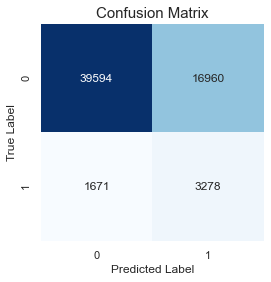

In [50]:
pred_test = model_rfc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [51]:
precision_4 = precision_score(Y_test, pred_test)
recall_4 = recall_score(Y_test, pred_test)

print('precision: ', precision_4)
print('recall: ', recall_4)

precision:  0.16197252692953848
recall:  0.6623560315215195


In [52]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_rfc['columntransformer'])):
    if bool:
        new_features.append(feature)

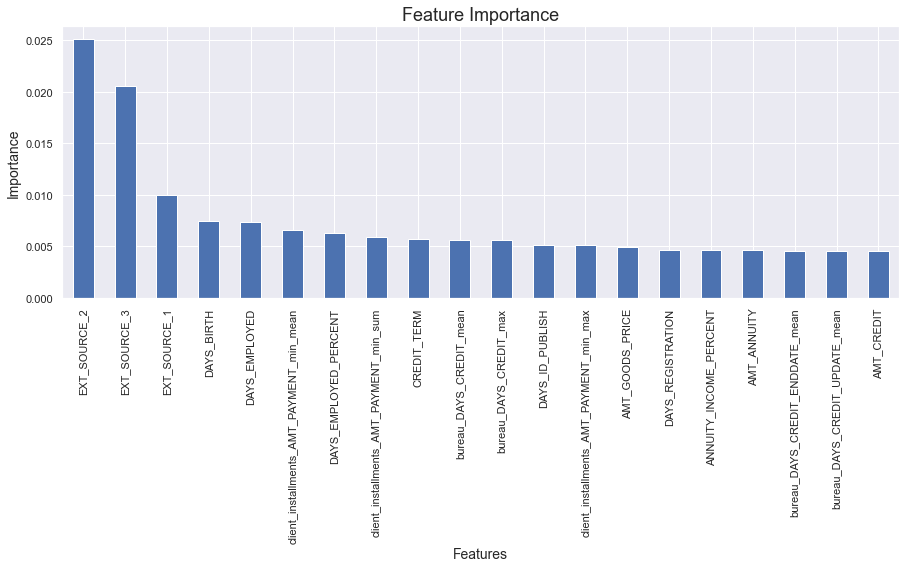

In [53]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [54]:
model_rfc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [55]:
model_rfc.fit(X_train_ros, Y_train_ros)
pred_5 = model_rfc.predict_proba(X_test)
pred_5 = pred_5[:, 1]

[14:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
auc_5 = roc_auc_score(Y_test, pred_5)
print('AUC: ', auc_5)

AUC:  0.7388330451097712


In [57]:
pred_5_t = model_rfc.predict_proba(X_train_ros)
pred_5_t = pred_5_t[:, 1]
auc_5_t = roc_auc_score(Y_train_ros, pred_5_t)
print('AUC: ', auc_5_t)

AUC:  1.0


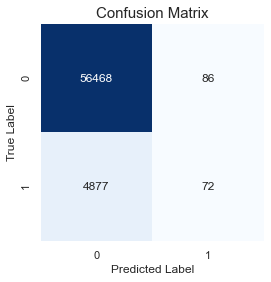

In [58]:
pred_test = model_rfc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [59]:
precision_5 = precision_score(Y_test, pred_test)
recall_5 = recall_score(Y_test, pred_test)

print('precision: ', precision_5)
print('recall: ', recall_5)

precision:  0.45569620253164556
recall:  0.014548393614871691


In [60]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_rfc['columntransformer'])):
    if bool:
        new_features.append(feature)

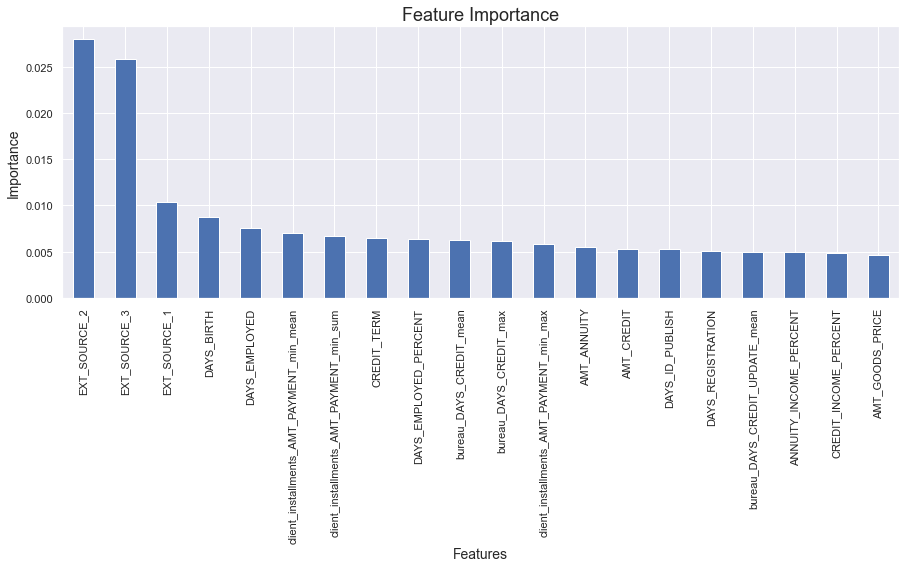

In [61]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [62]:
model_rfc = make_pipeline(SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [63]:
model_rfc.fit(X_train_smo, Y_train_smo)
pred_6 = model_rfc.predict_proba(X_test_smo)
pred_6 = pred_6[:, 1]

[14:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
auc_6 = roc_auc_score(Y_test, pred_6)
print('AUC: ', auc_6)

AUC:  0.5990578419809918


In [65]:
pred_6_t = model_rfc.predict_proba(X_train_smo)
pred_6_t = pred_6_t[:, 1]
auc_6_t = roc_auc_score(Y_train_smo, pred_6_t)
print('AUC: ', auc_6_t)

AUC:  1.0


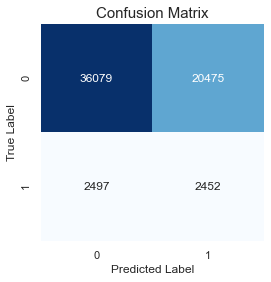

In [66]:
pred_test = model_rfc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [67]:
precision_6 = precision_score(Y_test, pred_test)
recall_6 = recall_score(Y_test, pred_test)

print('precision: ', precision_6)
print('recall: ', recall_6)

precision:  0.1069481397478955
recall:  0.4954536269953526


In [68]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

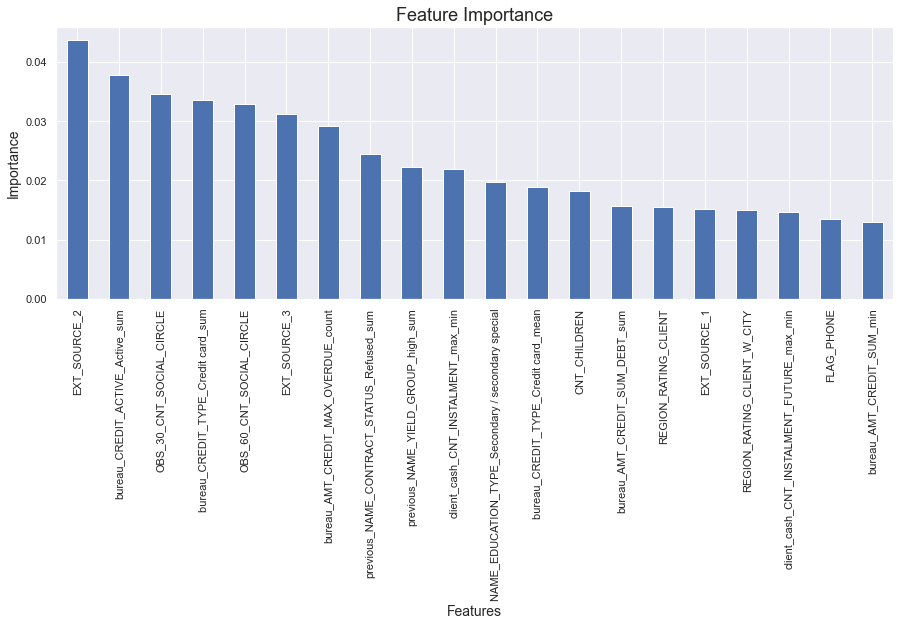

In [69]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

### 3.3. LGBMClassifier

#### With Under Sampling

In [70]:
model_lgbmc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [71]:
model_lgbmc.fit(X_train_rus, Y_train_rus)
pred_7 = model_lgbmc.predict_proba(X_test)
pred_7 = pred_7[:, 1]

[14:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [72]:
auc_7 = roc_auc_score(Y_test, pred_7)
print('AUC: ', auc_7)

AUC:  0.7797135156714983


In [73]:
pred_7_t = model_lgbmc.predict_proba(X_train_rus)
pred_7_t = pred_7_t[:, 1]
auc_7_t = roc_auc_score(Y_train_rus, pred_7_t)
print('AUC: ', auc_7_t)

AUC:  0.859720696472689


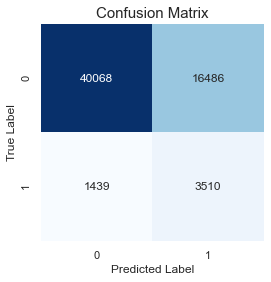

In [74]:
pred_test = model_lgbmc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [75]:
precision_7 = precision_score(Y_test, pred_test)
recall_7 = recall_score(Y_test, pred_test)

print('precision: ', precision_7)
print('recall: ', recall_7)

precision:  0.1755351070214043
recall:  0.709234188724995


In [76]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc['columntransformer'])):
    if bool:
        new_features.append(feature)

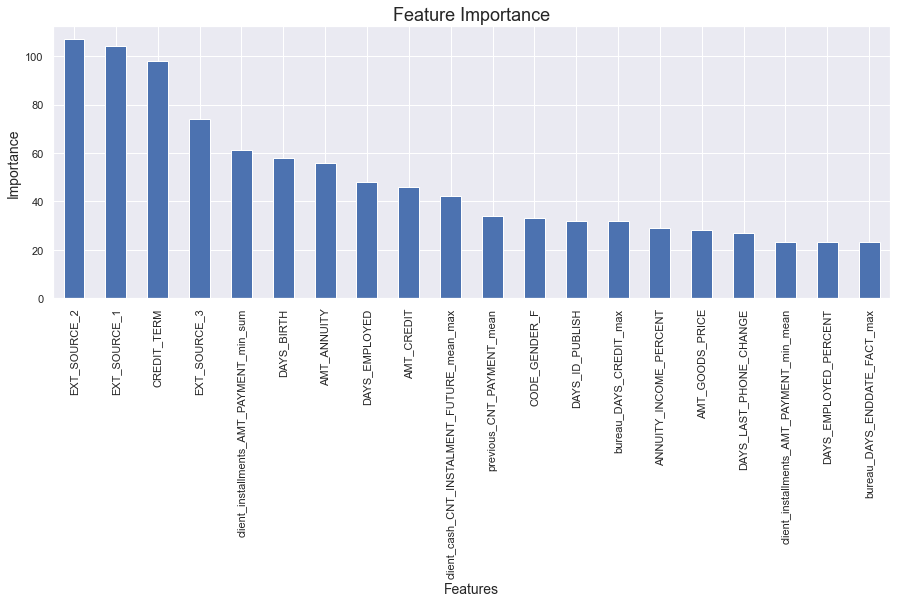

In [77]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [78]:
model_lgbmc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [79]:
model_lgbmc.fit(X_train_ros, Y_train_ros)
pred_8 = model_lgbmc.predict_proba(X_test)
pred_8 = pred_8[:, 1]

[14:47:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [80]:
auc_8 = roc_auc_score(Y_test, pred_8)
print('AUC: ', auc_8)

AUC:  0.7819989339507127


In [81]:
pred_8_t = model_lgbmc.predict_proba(X_train_ros)
pred_8_t = pred_8_t[:, 1]
auc_8_t = roc_auc_score(Y_train_ros, pred_8_t)
print('AUC: ', auc_8_t)

AUC:  0.8326968321383369


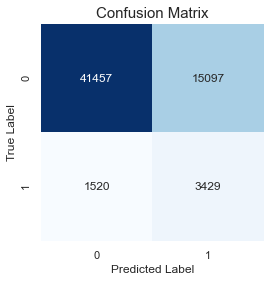

In [82]:
pred_test = model_lgbmc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [83]:
precision_8 = precision_score(Y_test, pred_test)
recall_8 = recall_score(Y_test, pred_test)

print('precision: ', precision_8)
print('recall: ', recall_8)

precision:  0.18509122314584908
recall:  0.6928672459082643


In [84]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc['columntransformer'])):
    if bool:
        new_features.append(feature)

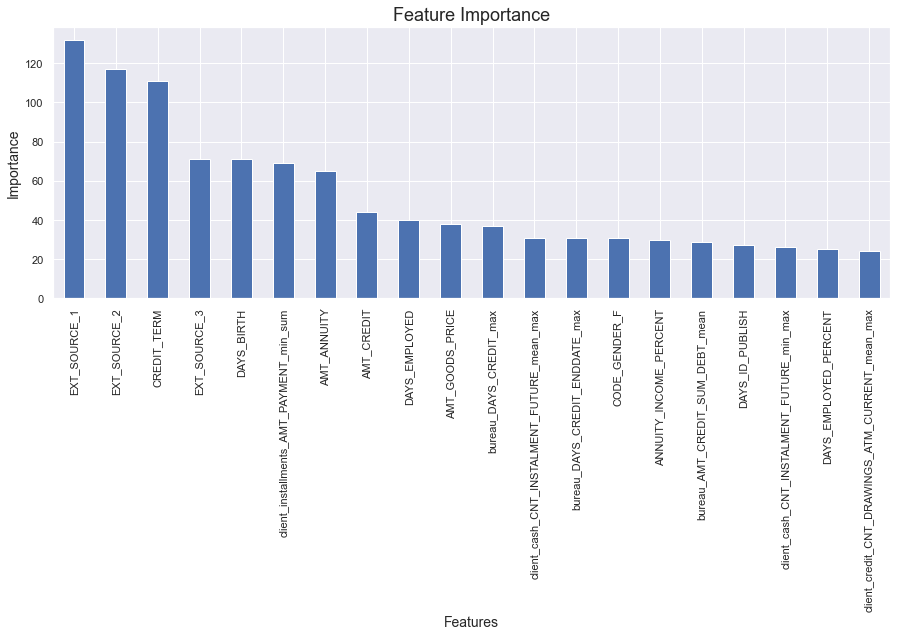

In [85]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [86]:
model_lgbmc = make_pipeline(SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [87]:
X_train_smo_b = X_train_smo.copy()

In [88]:
X_train_smo_b = X_train_smo_b.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [89]:
model_lgbmc.fit(X_train_smo_b, Y_train_smo)
pred_9 = model_lgbmc.predict_proba(X_test_smo)
pred_9 = pred_9[:, 1]

[14:58:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [90]:
auc_9 = roc_auc_score(Y_test, pred_9)
print('AUC: ', auc_9)

AUC:  0.6948658435789009


In [91]:
pred_9_t = model_lgbmc.predict_proba(X_train_smo)
pred_9_t = pred_9_t[:, 1]
auc_9_t = roc_auc_score(Y_train_smo, pred_9_t)
print('AUC: ', auc_9_t)

AUC:  0.9808170877421883


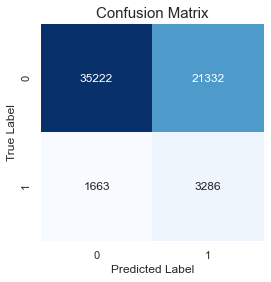

In [92]:
pred_test = model_lgbmc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [93]:
precision_9 = precision_score(Y_test, pred_test)
recall_9 = recall_score(Y_test, pred_test)

print('precision: ', precision_9)
print('recall: ', recall_9)

precision:  0.13347956779592168
recall:  0.6639725197009497


In [94]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

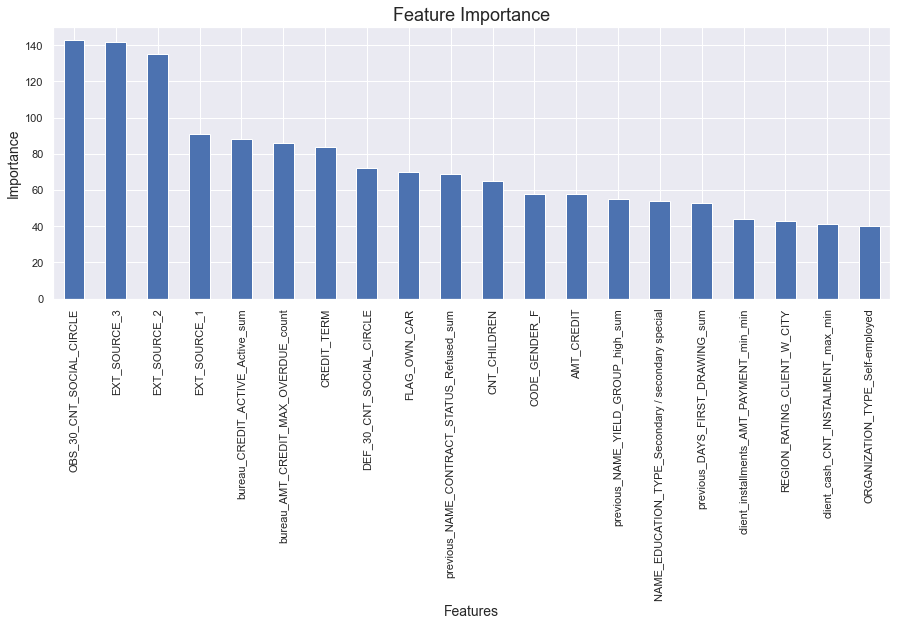

In [95]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index=new_features, columns=['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending=False)[:20].plot.bar(y='Importance')
plt.title('Feature Importance', fontsize=18)
plt.xlabel('Features', size=14)
plt.ylabel('Importance', size=14)
plt.show()

### 3.4. XGBClassifier

#### With Under Sampling

In [96]:
model_xgbc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [97]:
model_xgbc.fit(X_train_rus, Y_train_rus)
pred_10 = model_xgbc.predict_proba(X_test)
pred_10 = pred_10[:, 1]

[15:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:15:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [98]:
auc_10 = roc_auc_score(Y_test, pred_10)
print('AUC: ', auc_10)

AUC:  0.7642614140128452


In [99]:
pred_10_t = model_xgbc.predict_proba(X_train_rus)
pred_10_t = pred_10_t[:, 1]
auc_10_t = roc_auc_score(Y_train_rus, pred_10_t)
print('AUC: ', auc_10_t)

AUC:  0.9497085428853904


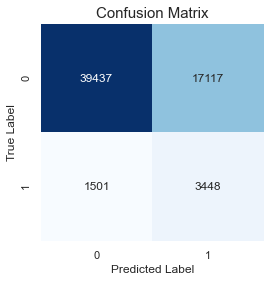

In [100]:
pred_test = model_xgbc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [101]:
precision_10 = precision_score(Y_test, pred_test)
recall_10 = recall_score(Y_test, pred_test)

print('precision: ', precision_10)
print('recall: ', recall_10)

precision:  0.16766350595672258
recall:  0.696706405334411


In [102]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_xgbc['columntransformer'])):
    if bool:
        new_features.append(feature)

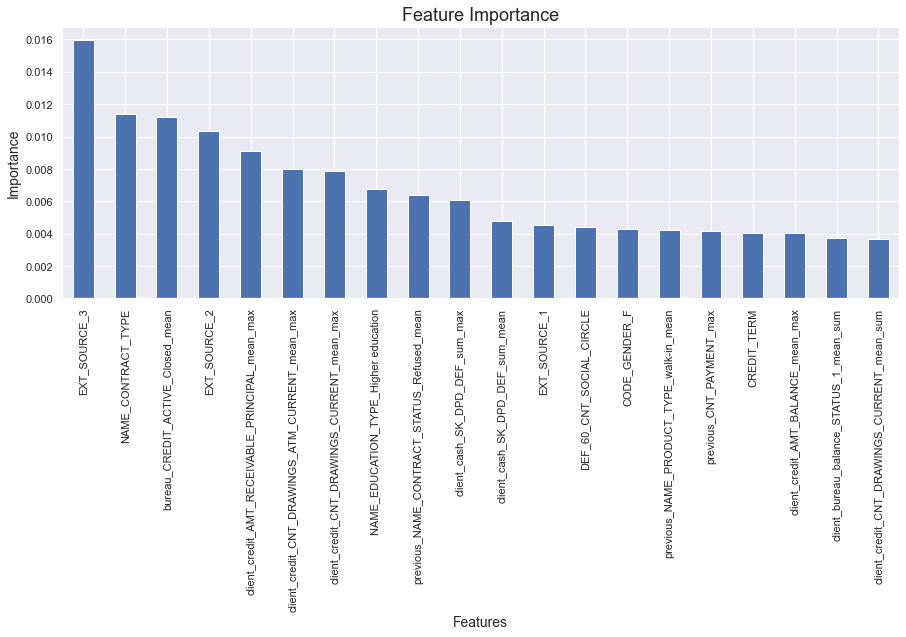

In [103]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [104]:
model_xgbc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [105]:
model_xgbc.fit(X_train_ros, Y_train_ros)
pred_11 = model_xgbc.predict_proba(X_test)
pred_11 = pred_11[:, 1]

[15:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [106]:
auc_11 = roc_auc_score(Y_test, pred_11)
print('AUC: ', auc_11)

AUC:  0.7659235333120538


In [107]:
pred_11_t = model_xgbc.predict_proba(X_train_ros)
pred_11_t = pred_11_t[:, 1]
auc_11_t = roc_auc_score(Y_train_ros, pred_11_t)
print('AUC: ', auc_11_t)

AUC:  0.9048210457264836


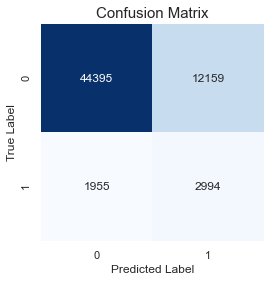

In [108]:
pred_test = model_xgbc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [109]:
precision_11 = precision_score(Y_test, pred_test)
recall_11 = recall_score(Y_test, pred_test)

print('precision: ', precision_11)
print('recall: ', recall_11)

precision:  0.19758463670560286
recall:  0.6049707011517478


In [110]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_xgbc['columntransformer'])):
    if bool:
        new_features.append(feature)

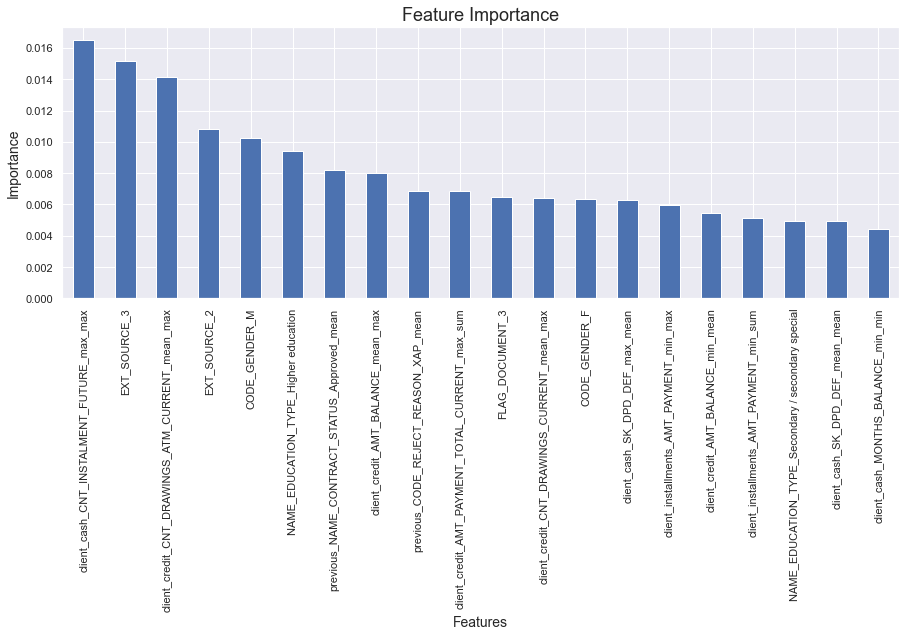

In [111]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [112]:
model_xgbc = make_pipeline(SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [113]:
model_xgbc.fit(X_train_smo, Y_train_smo)
pred_12 = model_xgbc.predict_proba(X_test_smo)
pred_12 = pred_12[:, 1]

[15:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [114]:
auc_12 = roc_auc_score(Y_test, pred_12)
print('AUC: ', auc_12)

AUC:  0.6343231552063391


In [115]:
pred_12_t = model_xgbc.predict_proba(X_train_smo)
pred_12_t = pred_12_t[:, 1]
auc_12_t = roc_auc_score(Y_train_smo, pred_12_t)
print('AUC: ', auc_12_t)

AUC:  0.9858320469811913


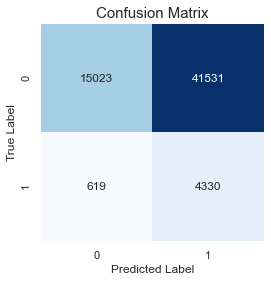

In [116]:
pred_test = model_xgbc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [117]:
precision_12 = precision_score(Y_test, pred_test)
recall_12 = recall_score(Y_test, pred_test)

print('precision: ', precision_12)
print('recall: ', recall_12)

precision:  0.09441573450208238
recall:  0.8749242271165892


In [118]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

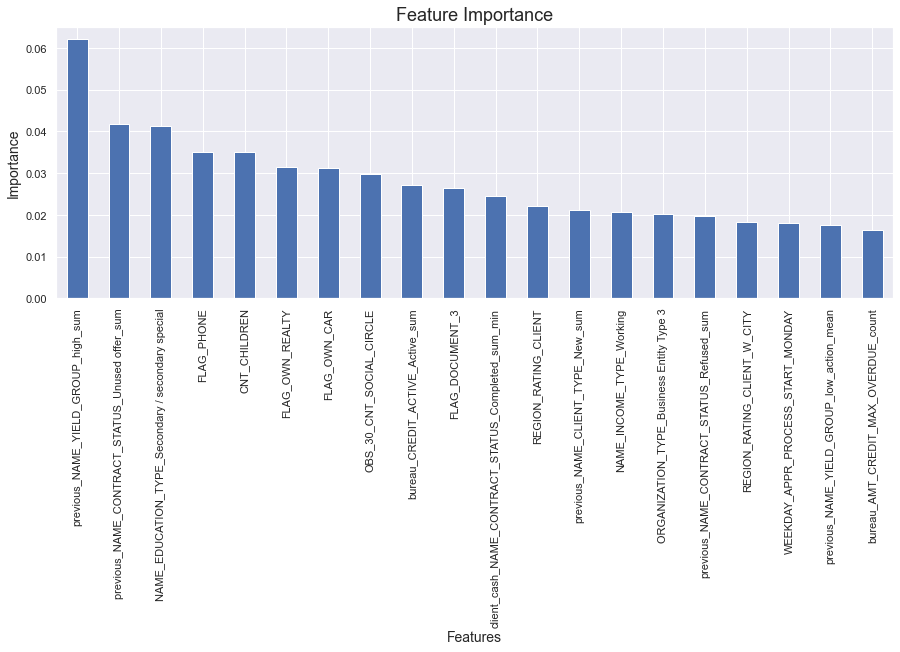

In [119]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

# 4. Results

In [120]:
model_name = ['Logistic Regression - RUS', 
              'Logistic Regression - ROS', 
              'Logistic Regression - SMOTE',
              'Random Forest Classifier - RUS',
              'Random Forest Classifier - ROS',
              'Random Forest Classifier - SMOTE',
              'LGBM Classifier - RUS',
              'LGBM Classifier - ROS',
              'LGBM Classifier - SMOTE',
              'XGB Classifier - RUS',
              'XGB Classifier - ROS',
              'XGB Classifier - SMOTE']

columns_name = ['AUC', 'AUC_Training', 'Precision', 'Recall']

df_result = pd.DataFrame(index = model_name, columns = columns_name)

In [121]:
count = 1
for i in model_name:
    df_result.loc[i, 'AUC'] = vars()['auc_' + str(count)]
    df_result.loc[i, 'AUC_Training'] = vars()['auc_' + str(count) + '_t']
    df_result.loc[i, 'Precision'] = vars()['precision_' + str(count)]
    df_result.loc[i, 'Recall'] = vars()['recall_' + str(count)]
    count = count + 1

In [122]:
df_result

,AUC,AUC_Training,Precision,Recall
Logistic Regression - RUS,0.773394,0.778354,0.17248,0.707416
Logistic Regression - ROS,0.772485,0.776872,0.172354,0.701152
Logistic Regression - SMOTE,0.739308,0.782576,0.161791,0.646999
Random Forest Classifier - RUS,0.746818,1,0.161973,0.662356
Random Forest Classifier - ROS,0.738833,1,0.455696,0.0145484
Random Forest Classifier - SMOTE,0.599058,1,0.106948,0.495454
LGBM Classifier - RUS,0.779714,0.859721,0.175535,0.709234
LGBM Classifier - ROS,0.781999,0.832697,0.185091,0.692867
LGBM Classifier - SMOTE,0.694866,0.980817,0.13348,0.663973
XGB Classifier - RUS,0.764261,0.949709,0.167664,0.696706
